In [1]:
import pickle
import yaml
import pandas as pd
import pickle
import sys
import numpy as np

import matplotlib.pyplot as plot

In [2]:
def loadConfig():    
    with open('./light_config_hulk.yaml', "r") as ymlfile: #hulk, slowloris; GE, heartbleed, slowhttp
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
import math

def calculateFalsePositives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsepositives = []
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fp_count = 0 # add
    tp_count = 0 # add
    truepos = [] # add
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agtIPList: # add
            fp_count = fp_count + 1 # add
        if IP + IPD in agt_attacks:
            tp_count = tp_count + 1            
            
        index = index + 1
        if index in cutOff :
            falsepositives.append(fp_count/numNormal)
            truepos.append(tp_count / len(agt_attacks)) #len(agt_attacks)) # add
            
    return falsepositives, truepos

def calc_eval(fpr, tpr, agt_norm, agt_attk):
    fpr = np.array(fpr[1:])
    tpr = np.array(tpr)

    Total = len(agt_norm)+len(agt_attk) #len(userScoreP)
    TotalN = len(agt_norm)
    TotalP = Total-TotalN
    FP = fpr*TotalN
    TN = TotalN - FP
    TP = tpr*TotalP
    FN = TotalP-TP
    
    Accr = (TP+TN) / (TP+TN+FP+FN)
    FPR = FP / (FP + TN)
    Prec = TP / (TP + FP)
    Rec = TP / (TP + FN)
    F1 = 2 * ((Prec*Rec) / (Prec+Rec))

    return (Accr, FPR, Prec, Rec, F1)

In [4]:
def plotAndSaveGraph(P, PQ_online, PQ_offline, iter_one, iter_offline, config, plt=False, metric=None):
    percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plot.rcParams['figure.figsize'] = [9, 9]
    fig = plot.figure()
    ax = plot.subplot(111)
    ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
#     ax.plot(percentages, P, linewidth=2, linestyle=':', markersize=9, label = "N Only")
    ax.plot(percentages, PQ_online, linewidth=2, linestyle='--', markersize=9, label = "Enhanced N/D (ℓ=1)") #With Transfer")
    ax.plot(percentages, PQ_offline, linewidth=2, linestyle='-.', markersize=9, label = "N/D (ℓ=1)") #Without Transfer") 
    ax.plot(percentages, iter_one, linewidth=2, linestyle='--', marker='o', markersize=9, label = "Enhanced Iter. (ℓ=1)") #Without Transfer")
    ax.plot(percentages, iter_offline, linewidth=2, linestyle='--', marker='s', markersize=9, label = "Iter. Classifier (ℓ=1)") #(ℓ=∞)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=18)
    if plt:
        if metric == 'F_pos':
            plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPos-Graph')
        if metric == 'F_neg':
            plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FNeg-Graph')

### Test set

In [5]:
# #Load User Scores
userScoreP = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore', 'rb'))
userScoreP = userScoreP.sort_values(by = ['P'],ascending=True) # add

userScorePQ_online = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score', 'rb'))
userScorePQ_online = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=True) # add 

userScorePQ_offline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score', 'rb'))
userScorePQ_offline = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=True) 

# userScoreQonline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ', 'rb'))
# userScoreQonline = userScoreQonline.sort_values(by = ['QWithT'],ascending=True)

# userScoreQoffline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ', 'rb'))
# userScoreQoffline = userScoreQoffline.sort_values(by = ['QWithoutT'],ascending=True)

print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  12996


In [6]:
len(userScoreP)

12996

In [7]:
sum(userScoreP['Source IP'] == '999.16.30.0')

10000

In [8]:
import matplotlib.pyplot as plt
# attacker='172.16.0.1'; victim='192.168.10.50' # original attacker
attacker='999.16.30.0'; victim='999.16.30.1' # mimic attacker

# def showscore(scoretype, scores):
#     fig = plt.figure(figsize=(7,5))
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == victim], bins=20, alpha=0.5, label='victim') 
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == attacker], bins=20, alpha=0.5, label='attcker')
#     plt.legend(loc='upper right')
#     plt.show()
def showscore(scoretype, scores):
    fig = plt.figure(figsize=(7,5))
    plt.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, alpha=0.5, label='victim') 
    plt.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, alpha=0.5, label='attcker')
    plt.legend(loc='upper right')
    plt.show()
    return fig

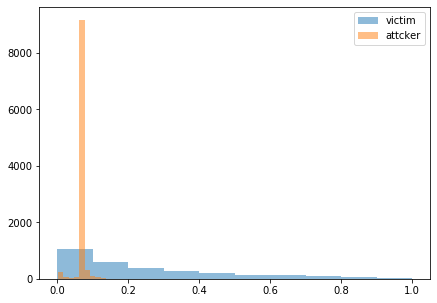

In [9]:
# add standardization
std_userScoreP = userScoreP
std_userScoreP['P'] = (std_userScoreP['P'] - std_userScoreP['P'].min(axis=0)) / (std_userScoreP['P'].max(axis=0) - std_userScoreP['P'].min(axis=0))

fig = showscore(userScoreP, 'P') # P scores

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_P_distr' + '.png')

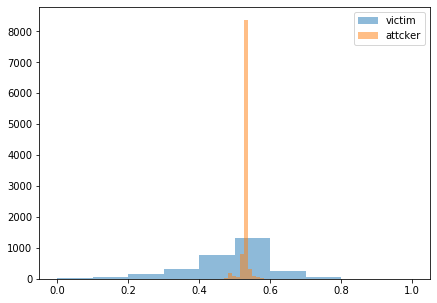

In [10]:
# add standardization
std_userScorePQ_online = userScorePQ_online
std_userScorePQ_online['PoverQ_online'] = (std_userScorePQ_online['PoverQ_online'] - std_userScorePQ_online['PoverQ_online'].min(axis=0)) / (std_userScorePQ_online['PoverQ_online'].max(axis=0) - std_userScorePQ_online['PoverQ_online'].min(axis=0))

fig = showscore(std_userScorePQ_online, 'PoverQ_online') # online Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQonline_distr' + '.png')

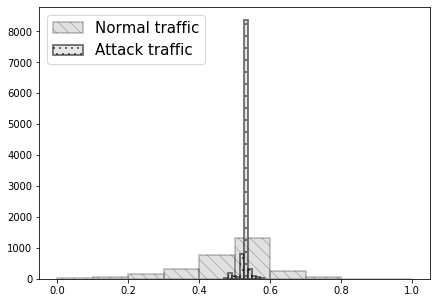

In [11]:
scoretype=std_userScorePQ_online; scores='PoverQ_online'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper left',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_NDonline_distr' + '.png')

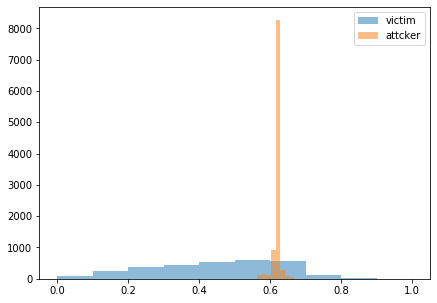

In [12]:
# add standardization
std_userScorePQ_offline = userScorePQ_offline
std_userScorePQ_offline['PoverQ_offline'] = (std_userScorePQ_offline['PoverQ_offline'] - std_userScorePQ_offline['PoverQ_offline'].min(axis=0)) / (std_userScorePQ_offline['PoverQ_offline'].max(axis=0) - std_userScorePQ_offline['PoverQ_offline'].min(axis=0))

fig = showscore(std_userScorePQ_offline, 'PoverQ_offline') # offline Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQoffline_distr' + '.png')

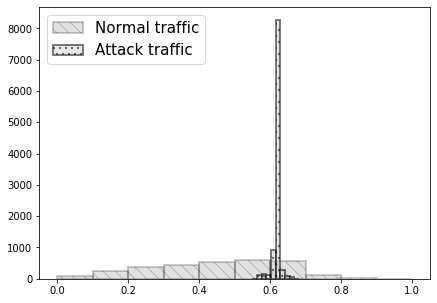

In [13]:
scoretype=std_userScorePQ_offline; scores='PoverQ_offline'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper left',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_NDoffline_distr' + '.png')

### Predicted P-only user scores

In [14]:
print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  12996


In [15]:
agt_normals = []
agt_attacks = []
# attacker='172.16.0.1'; victim='192.168.10.50'
attacker1='999.16.30.0'; victim='999.16.30.1' # victim='192.168.10.50'
print("Length of userScoreP: ", len(userScoreP))

for (IP, IPD, score) in list(userScoreP.itertuples(index=False, name=None)):
#     if (IP != '172.16.0.1' and  IPD=='192.168.10.50') or IP == '192.168.10.50': 
#     if (IP != attacker and  IPD==victim) or IP == victim: 
    if IP == attacker or IP == victim:
        agt_attacks.append(IP+IPD)
    else:
        agt_normals.append(IP + IPD)
        

print("Length of Normal traffic: ", len(agt_normals))
print("Length of true attacks: ", len(agt_attacks))

#Plot some graphs
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num = len(agt_normals)
print("Percent attacks: ", len(agt_attacks)/len(userScoreP))

Length of userScoreP:  12996
Length of Normal traffic:  2996
Length of true attacks:  10000
Percent attacks:  0.7694675284702985


In [16]:
''' Countermeasure!!!! '''
# HULK
# Length of test data:  11710
# Number of normal traffic:  4552
# Number of true attacks:  7158
# Percent attacks:  0.611272416737831

classifier_rejectthres = 0.6 #0.5099
fp_classifier = 0.028119507908611598 #0.007249560632688928

# Mimic results (FPR)
# (ℓ = ∞)
# iter_classifier = [0,
#  0.3220961281708945,
#  0.3484646194926569,
#  0.3638184245660881,
#  0.37983978638184246,
#  0.3901869158878505,
#  0.4015353805073431,
#  0.414218958611482,
#  0.4329105473965287,
#  0.45994659546061417,
#  1.0]

# (ℓ = 1)
iter_classifier_one = [0,
 0.14352469959946595,
 0.20627503337783712,
 0.2530040053404539,
 0.2963951935914553,
 0.33978638184245663,
 0.3818424566088118,
 0.43124165554072097,
 0.4939919893190921,
 0.6178237650200267,
 1.0]

In [37]:
''' Countermeasure!!!! '''
# Mimic results (FNR)
# (ℓ = ∞)
iter_offline_fnr = [0,
 0.0803,
 0.1035,
 0.1203,
 0.1348,
 0.1512,
 0.1708,
 0.1899,
 0.2169,
 0.2662,
 1.0]

# (ℓ = 1)
iter_one_fnr = [0,
 0.2559,
 0.3539,
 0.4222,
 0.4768,
 0.5218,
 0.5673,
 0.6234,
 0.6886,
 0.7825,
 1.0]

In [18]:
graphP, P_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScoreP, percentages, num)
graphPQ_online, onlinePQ_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_online, percentages, num)
graphPQ_offline, offlinePQ_tpr  = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_offline, percentages, num)
# graphQonline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQonline, percentages, num)
# graphQoffline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQoffline, percentages, num)   

graphP.insert(0, 0)
graphPQ_online.insert(0, 0)
graphPQ_offline.insert(0, 0)
# graphQonline.insert(0, 0)
# graphQoffline.insert(0, 0)

In [40]:
''' No countermeasure!!!!! '''
atkFPR_PQonline = [0, 0.40520694259012, 0.53671562082777, 0.564085447263017, 0.580106809078772, 0.588785046728972, 0.599799732977303, 0.617823765020027, 0.643190921228304, 0.679906542056075, 1.0]

atkFPR_iter_one = [0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

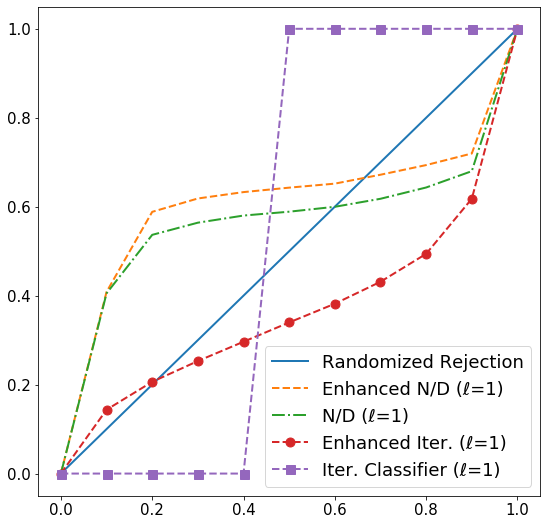

In [42]:
# plotAndSaveGraph(graphPQ_online, graphP, graphPQ_offline, classifier_rejectthres, fp_classifier, 
#                  iter_classifier_one, iter_classifier, config) #, plt=True)

plotAndSaveGraph(graphP, graphPQ_online, atkFPR_PQonline, 
                 iter_classifier_one, atkFPR_iter_one, config) #, plt=True, metric='F_pos')

### Calculate False Negatives

In [31]:
def calculateFalseNegatives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsenegatives = [] #ADD
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fn_count = 0 #ADD
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agt_attacks: # ADD
            fn_count = fn_count + 1 # ADD
            
        index = index + 1
        if index in cutOff :
            falsenegatives.append(fn_count/len(agt_attacks)) #numNormal) # ADD
            
    return falsenegatives

In [32]:
# #Inverse User Scores
userScoreP_inv = userScoreP.sort_values(by = ['P'],ascending=False) # add
# userScoreP_inv
userScorePQ_online_inv = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=False) # add 
userScorePQ_offline_inv = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=False) 

print("Length of userScoreP: ", userScoreP_inv[:5]) #len(userScoreP))

Length of userScoreP:              Source IP          Dest IP         P
10445  74.121.138.148    192.168.10.17  1.000000
10108   172.217.6.193    192.168.10.19  0.989138
9550    172.217.6.193    192.168.10.19  0.989138
2890     192.168.10.8  222.161.220.100  0.967347
7094    192.168.10.19    211.233.74.23  0.967085


In [33]:
graphP_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScoreP_inv, percentages, num)
graphPQ_online_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScorePQ_online_inv, percentages, num)
graphPQ_offline_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScorePQ_offline_inv, percentages, num)


graphP_fnr.insert(0, 0)
graphPQ_online_fnr.insert(0, 0)
graphPQ_offline_fnr.insert(0, 0)

In [34]:
print(graphP_fnr)
print(graphPQ_online_fnr)
print(graphPQ_offline_fnr)

[0, 0.0, 0.0447, 0.158, 0.2809, 0.4065, 0.5322, 0.658, 0.7843, 0.9112, 1.0]
[0, 0.046, 0.1682, 0.2916, 0.4156, 0.5428, 0.6698, 0.7955, 0.9164, 0.9925, 1.0]
[0, 0.086, 0.2137, 0.3407, 0.4658, 0.5934, 0.7213, 0.8489, 0.9654, 1.0, 1.0]


In [43]:
''' No countermeasure!!!!! '''
atkFNR_PQonline = [0, 0.0319, 0.149, 0.2732, 0.3955, 0.5225, 0.6488, 0.7747, 0.8997, 0.9968, 1.0]

atkFNR_iter_one = [0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

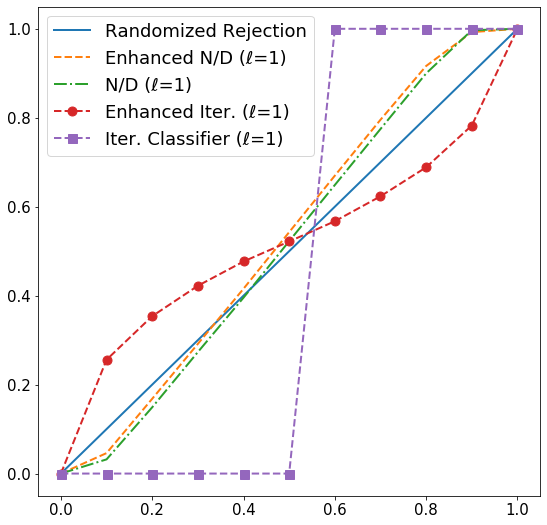

In [46]:
plotAndSaveGraph(graphP_fnr, graphPQ_online_fnr, atkFNR_PQonline, 
                 iter_one_fnr, atkFNR_iter_one, config) #, plt=True, metric='F_neg')

### Calculate evaluation metrics 

In [47]:
P_metrics = np.array(np.transpose(calc_eval(graphP, P_tpr, agt_normals, agt_attacks)))
P_metrics = np.concatenate((P_metrics, np.reshape(graphP_fnr[1:], (-1, 1))), axis=1)

onlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_online, onlinePQ_tpr, agt_normals, agt_attacks)))
onlinePQ_metrics = np.concatenate((onlinePQ_metrics, np.reshape(graphPQ_online_fnr[1:], (-1, 1))), axis=1)

offlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_offline, offlinePQ_tpr, agt_normals, agt_attacks)))
offlinePQ_metrics = np.concatenate((offlinePQ_metrics, np.reshape(graphPQ_offline_fnr[1:], (-1, 1))), axis=1)


P_metrics = pd.DataFrame(P_metrics, columns=['Accr_P', 'FPR_P', 'Prec_P', 'Rec_P', 'F1_P', 'FNR_P'])
onlinePQ_metrics = pd.DataFrame(onlinePQ_metrics, columns=['Accr_onPQ', 'FPR_onPQ', 
                                                           'Prec_onPQ', 'Rec_onPQ', 'F1_onPQ', 'FNR_onPQ'])
offlinePQ_metrics = pd.DataFrame(offlinePQ_metrics, columns=['Accr_offPQ', 'FPR_offPQ', 
                                                             'Prec_offPQ', 'Rec_offPQ', 'F1_offPQ', 'FNR_offPQ'])
df_FPresults = pd.concat([P_metrics,onlinePQ_metrics,offlinePQ_metrics],axis=1)

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [49]:
# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_allPQresults.csv", index=False)

# Rows 3=0.4, 4=0.5, 5=0.6
df_FPresults#.iloc[4]

,Accr_P,FPR_P,Prec_P,Rec_P,F1_P,FNR_P,Accr_onPQ,FPR_onPQ,Prec_onPQ,Rec_onPQ,F1_onPQ,FNR_onPQ,Accr_offPQ,FPR_offPQ,Prec_offPQ,Rec_offPQ,F1_offPQ,FNR_offPQ
0,0.267313,0.137183,0.683846,0.0889,0.157345,0.0000,0.142198,0.408545,0.058462,0.0076,0.013451,0.0460,0.130502,0.433912,0.000000,0.0000,NaN,0.0860
1,0.362573,0.147530,0.830000,0.2158,0.342540,0.0447,0.159280,0.588451,0.321923,0.0837,0.132857,0.1682,0.083872,0.752003,0.133462,0.0347,0.055079,0.2137
2,0.456987,0.159546,0.877404,0.3421,0.492266,0.1580,0.245383,0.618491,0.524750,0.2046,0.294410,0.2916,0.163050,0.797063,0.387535,0.1511,0.217426,0.3407
3,0.550554,0.173565,0.899981,0.4679,0.615698,0.2809,0.338797,0.632844,0.635314,0.3303,0.434634,0.4156,0.259541,0.804740,0.536257,0.2788,0.366866,0.4658
4,0.643890,0.187917,0.913358,0.5935,0.719481,0.4065,0.434134,0.642857,0.703601,0.4572,0.554249,0.5428,0.356263,0.811749,0.625731,0.4066,0.492908,0.5934
5,0.737304,0.202270,0.922288,0.7192,0.808181,0.5322,0.530009,0.651869,0.749551,0.5845,0.656815,0.6698,0.452755,0.819426,0.685176,0.5343,0.600405,0.7213
6,0.826408,0.225968,0.925588,0.8421,0.881872,0.6580,0.620806,0.671896,0.778743,0.7085,0.741963,0.7955,0.545245,0.835781,0.724775,0.6594,0.690544,0.8489
7,0.900662,0.281709,0.918823,0.9553,0.936706,0.7843,0.710757,0.693591,0.800135,0.8319,0.815708,0.9164,0.640736,0.845461,0.756372,0.7864,0.771094,0.9654
8,0.869421,0.566422,0.854920,1.0000,0.921786,0.9112,0.798784,0.719626,0.815679,0.9541,0.879476,0.9925,0.737227,0.853138,0.781482,0.9141,0.842605,1.0000
9,0.769468,1.000000,0.769468,1.0000,0.869716,1.0000,0.769468,1.000000,0.769468,1.0000,0.869716,1.0000,0.769468,1.000000,0.769468,1.0000,0.869716,1.0000


### Calculate evaluation metrics 

In [ ]:
graphP = np.array(graphP)
graphPQ= np.array(graphPQ_online)
graphPQTil= np.array(graphPQ_offline)

df_FPresults = pd.DataFrame({"P_FP":graphP[1:], "OnlineQ_FP":graphPQ[1:], "OfflineQ_FP":graphPQTil[1:], 
                             "Accr":Accr, "FPR":FPR, "Precision":Prec, 
                             "Recall":Rec, "F1_score":F1})

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_FPresults.csv", index=False)

In [ ]:
df_FPresults